## About
Furniture detection via Faster RCNN with Resnet 50 as feature extractor.

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/MyDrive/Datasets/')
!unzip furniture.zip

In [1]:
# importing libraries
import numpy as np
import torch
import pandas as pd
import torchvision
import os
from torchvision import datasets,models
from torchvision.transforms import functional as F
from torchvision import transforms as T
from torch import nn, optim
from torch.utils.data import DataLoader, sampler, random_split, Dataset
import copy
import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict,deque
import datetime
import math
from tqdm import tqdm
from torchvision.utils import draw_bounding_boxes
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image, ImageEnhance
import torchvision.transforms as transforms
import cv2
from typing_extensions import Concatenate

import albumentations as A
from albumentations.pytorch import ToTensorV2
from pycocotools.coco import COCO

In [2]:
#image enhancement function while training
enhancers = {
    0: lambda image, f: ImageEnhance.Color(image).enhance(f),
    1: lambda image, f: ImageEnhance.Contrast(image).enhance(f),
    2: lambda image, f: ImageEnhance.Brightness(image).enhance(f),
    3: lambda image, f: ImageEnhance.Sharpness(image).enhance(f)
}

factors = {
        0: lambda: np.random.normal(1.0, 0.3),
        1: lambda: np.random.normal(1.0, 0.1),
        2: lambda: np.random.normal(1.0, 0.1),
        3: lambda: np.random.normal(1.0, 0.3),
    }
    

def enhance(image):
    order = [0, 1, 2, 3]
    np.random.shuffle(order)
    for i in order:
        f = factors[i]()
        image = enhancers[i](image, f)
    return image

In [3]:
train_transform = A.Compose([
    #using albumentations for transforms instead of torchvision's transforms
    A.Resize(600, 600),
    A.VerticalFlip(p=0.2),
    A.HorizontalFlip(p=0.2),
    A.RandomBrightnessContrast(p=0.2),
    A.ColorJitter(p=0.1),
    ToTensorV2()], bbox_params = A.BboxParams(format='coco'))


val_transform = A.Compose([
    #using albumentations for transforms instead of torchvision's transforms
    A.Resize(600, 600),
    ToTensorV2()], bbox_params = A.BboxParams(format='coco'))


In [4]:
class FurnitureDataset(datasets.VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None, transforms=None):
        # the 3 transform parameters are reuqired for datasets.VisionDataset
        super().__init__(root, transforms, transform, target_transform)
        self.split = split #train, valid, test
        self.coco = COCO(os.path.join(root, split, "_annotations.coco.json")) 
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.ids = [id for id in self.ids if (len(self._load_target(id)) > 0)]
    
    def _load_image(self, id: int):
        path = self.coco.loadImgs(id)[0]['file_name']
        image = cv2.imread(os.path.join(self.root, self.split, path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image
    def _load_target(self, id):
        return self.coco.loadAnns(self.coco.getAnnIds(id))
    
    def __getitem__(self, index):
        id = self.ids[index]
        image = self._load_image(id)
        target = self._load_target(id)
        target = copy.deepcopy(self._load_target(id))
        
        boxes = [t['bbox'] + [t['category_id']] for t in target] # required annotation format for albumentations
        if self.transforms is not None:
            transformed = self.transforms(image=image, bboxes=boxes)
        
        image = transformed['image']
        boxes = transformed['bboxes']
        
        new_boxes = [] # convert from xywh to xyxy
        for box in boxes:
            xmin = box[0]
            xmax = xmin + box[2]
            ymin = box[1]
            ymax = ymin + box[3]
            new_boxes.append([xmin, ymin, xmax, ymax])
        
        boxes = torch.tensor(new_boxes, dtype=torch.float32)
        
        targ = {} # here is our transformed target
        targ['boxes'] = boxes
        targ['labels'] = torch.tensor([t['category_id'] for t in target], dtype=torch.int64)
        targ['image_id'] = torch.tensor([t['image_id'] for t in target])
        targ['area'] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) # we have a different area
        targ['iscrowd'] = torch.tensor([t['iscrowd'] for t in target], dtype=torch.int64)
        return image.div(255), targ # scale images
    def __len__(self):
        return len(self.ids)

In [5]:
dataset_path = "/content/drive/MyDrive/Datasets/furniture/"

In [12]:
#load classes
coco = COCO(os.path.join(dataset_path, "train", "_annotations.coco.json"))
categories = coco.cats
n_classes = len(categories.keys())
categories

loading annotations into memory...
Done (t=3.49s)
creating index...
index created!


{0: {'id': 0, 'name': 'furniture', 'supercategory': 'none'},
 1: {'id': 1, 'name': 'Chair', 'supercategory': 'furniture'},
 2: {'id': 2, 'name': 'Sofa', 'supercategory': 'furniture'},
 3: {'id': 3, 'name': 'Table', 'supercategory': 'furniture'}}

In [13]:
classes = [i[1]['name'] for i in categories.items()]
classes

['furniture', 'Chair', 'Sofa', 'Table']

In [14]:
train_dataset = FurnitureDataset(root=dataset_path, transforms=train_transform)
val_dataset = FurnitureDataset(root=dataset_path, transforms=val_transform)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [15]:
print("{} :: Length of train dataset".format(len(train_dataset)))
print("{} :: Length of val dataset".format(len(val_dataset)))

454 :: Length of train dataset
454 :: Length of val dataset


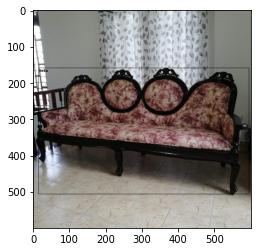

In [16]:
#visualising
train_sample = train_dataset[2]
image = torch.tensor(train_sample[0] * 255, dtype=torch.uint8)
plt.imshow(draw_bounding_boxes(
    image, train_sample[1]['boxes'], [classes[i] for i in train_sample[1]['labels']]
).permute(1, 2, 0))

In [17]:
# loading the resnet model and chaning its classification head
model = models.detection.fasterrcnn_resnet50_fpn_v2(pretrained=True)


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth


  0%|          | 0.00/167M [00:00<?, ?B/s]

In [18]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

In [19]:
in_features = model.roi_heads.box_predictor.cls_score.in_features 
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes)

In [20]:
#collate function for loading data in batches easily
def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn=collate_fn)

In [21]:
device = torch.device("cuda")
torch.cuda.is_available()

True

In [22]:
model = model.to(device)

In [23]:
optimizer = torch.optim.Adam(model.parameters())


In [99]:
def fit(num_epochs,model, optimizer, train_loader):
    device = torch.device("cuda")
    for epoch in range(num_epochs):
      model.to(device)
      model.train()
      
      net_loss = []
      net_loss_dict = []
      
      for images, targets in tqdm(train_loader):
          images = list(image.to(device) for image in images)
          targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]
          
          loss_dict = model(images, targets) 
          losses = sum(loss for loss in loss_dict.values())
          loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
          loss_value = losses.item()
          
          net_loss.append(loss_value)
          net_loss_dict.append(loss_dict_append)
          
          
          #backpropagating
          losses.backward()
          #updating gradients
          optimizer.step()
          #resetting grad
          optimizer.zero_grad()
          

          
      net_loss_dict = pd.DataFrame(net_loss_dict) 
      print("Epoch {}, Train loss: {:.4f}, Train Loss of classifier head: {:.4f}, Train loss of bbox: {:.4f}, Train loss of region proposal network: {:.4f}, Train loss of object detection: {:.4f}".format(
          epoch,np.mean(net_loss),
          net_loss_dict['loss_classifier'].mean(),
          net_loss_dict['loss_box_reg'].mean(),
          net_loss_dict['loss_rpn_box_reg'].mean(),
          net_loss_dict['loss_objectness'].mean()
      ))
    return net_loss_dict
      

In [102]:
history = fit(5,model,optimizer,train_loader)

100%|██████████| 114/114 [02:25<00:00,  1.28s/it]


Epoch 0, Train loss: 0.0621, Train Loss of classifier head: 0.0205, Train loss of bbox: 0.0375, Train loss of region proposal network: 0.0024, Train loss of object detection: 0.0016


100%|██████████| 114/114 [02:29<00:00,  1.31s/it]


Epoch 1, Train loss: 0.0591, Train Loss of classifier head: 0.0201, Train loss of bbox: 0.0358, Train loss of region proposal network: 0.0022, Train loss of object detection: 0.0010


100%|██████████| 114/114 [02:31<00:00,  1.33s/it]


Epoch 2, Train loss: 0.0586, Train Loss of classifier head: 0.0206, Train loss of bbox: 0.0346, Train loss of region proposal network: 0.0020, Train loss of object detection: 0.0014


100%|██████████| 114/114 [02:32<00:00,  1.34s/it]


Epoch 3, Train loss: 0.0485, Train Loss of classifier head: 0.0160, Train loss of bbox: 0.0287, Train loss of region proposal network: 0.0021, Train loss of object detection: 0.0016


100%|██████████| 114/114 [02:32<00:00,  1.34s/it]


Epoch 4, Train loss: 0.0523, Train Loss of classifier head: 0.0172, Train loss of bbox: 0.0309, Train loss of region proposal network: 0.0022, Train loss of object detection: 0.0020


In [103]:
torch.save(model.state_dict(), 'furniture_detect.pth')

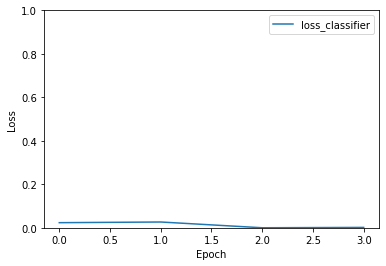

In [104]:
history = np.array(history)
plt.plot(history[0])
plt.legend(['loss_classifier'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0,1)
plt.show()

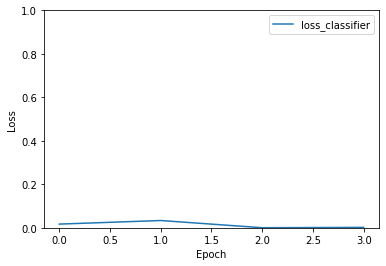

In [105]:
history = np.array(history)
plt.plot(history[1])
plt.legend(['loss_classifier'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0,1)
plt.show()

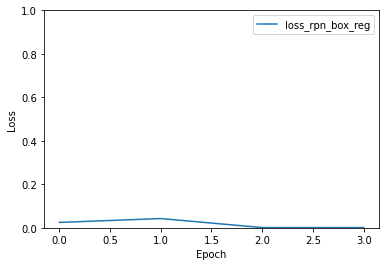

In [106]:
history = np.array(history)
plt.plot(history[2])
plt.legend(['loss_rpn_box_reg'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0,1)
plt.show()

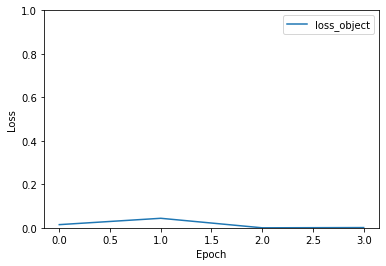

In [107]:
history = np.array(history)
plt.plot(history[3])
plt.legend(['loss_object'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0,1)
plt.show()

In [108]:
#evaluating on test
test_dataset = FurnitureDataset(root=dataset_path, split="test", transforms=val_transform)


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [112]:
model.eval()

img, _ = test_dataset[22]
img_uint = torch.tensor(img*255, dtype=torch.uint8)
with torch.no_grad():
    prediction = model([img.to(device)])
    pred = prediction[0]

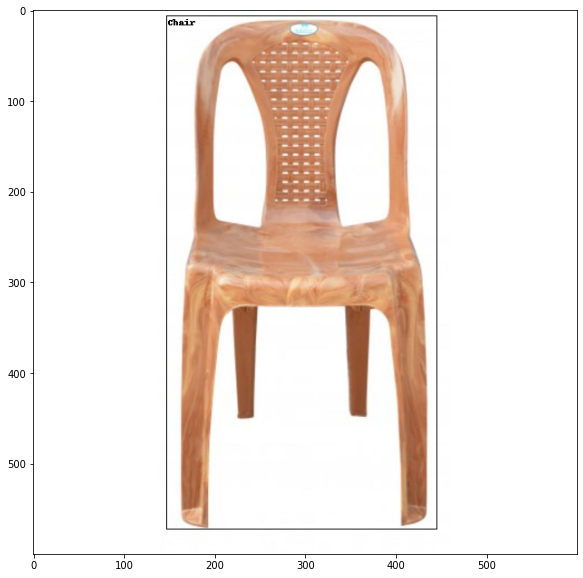

In [113]:
fig = plt.figure(figsize=(14, 10))
plt.imshow(draw_bounding_boxes(img_uint,
    pred['boxes'][pred['scores'] > 0.9],
    [classes[i] for i in pred['labels'][pred['scores'] > 0.9].tolist()]
).permute(1, 2, 0))